<a href="https://colab.research.google.com/github/kithmiGunawardna/Hate_Speech_detection/blob/master/Deep_learning_model_hate_speech_detection_Using_trained_word2Vec_(LSTM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade gensim
!pip install keras-preprocessing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.7 MB/s eta 0:00:00


In [ ]:
#import relevant libraraies
import pandas as pd
import numpy as np
from google.colab import drive

#imprtant libraris for visualization
import matplotlib.pyplot as plt
import seaborn as sns
# for deep learning

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import re
import string
from sklearn.utils import resample
from spacy.lang.en import English
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from sklearn.model_selection import train_test_split

import io
import re
import string
import tqdm

import numpy as np

import tensorflow as tf
from tensorflow.keras import layers

#word embading using pretrain model
from gensim.models import Word2Vec
from matplotlib import pyplot
from gensim.models import KeyedVectors
from tensorflow.keras.preprocessing.text import Tokenizer


#LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense


from keras.initializers import Constant
from keras.callbacks import EarlyStopping

#validation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score



#hide warning
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.preprocessing.sequence import pad_sequences


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


 0 - hate speech 1 - offensive language 2 - neither

In [ ]:
#import dataset
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/My Drive/Campus_Research/labeled_data.csv')

Mounted at /content/drive


In [ ]:
df

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


**Cleaning the dataset**

In [ ]:
#preprossesing part
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  stripped_mentions = tf.strings.regex_replace(stripped_html, r"@\w+", " ")
  stripped_hashtags = tf.strings.regex_replace(stripped_mentions, r"#\w+", " ")
  # Expand emoticons with appropriate library
  # stripped_emoticons = ...
  stripped_urls = tf.strings.regex_replace(stripped_hashtags, r"http(?s://)?\S+", " ")
  # Remove punctuation (existing logic)
  return tf.strings.regex_replace(stripped_urls, '[%s]' % re.escape(string.punctuation), '').numpy().decode('utf-8')

In [ ]:
# Apply clean_text function
df.loc[:, 'tweet'] = df['tweet'].apply(custom_standardization)

In [ ]:
df

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,rt as a woman you shouldnt complain about c...
1,1,3,0,3,0,1,rt boy dats coldtyga dwn bad for cuffin dat...
2,2,3,0,3,0,1,rt dawg rt you ever fuck a bitch and she ...
3,3,3,0,2,1,1,rt she look like a tranny
4,4,6,0,6,0,1,rt the shit you hear about me might be true...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,yous a muthafin lie right his tl is tra...
24779,25292,3,0,1,2,2,youve gone and broke the wrong heart baby and ...
24780,25294,3,0,3,0,1,young buck wanna eat dat nigguh like i aint fu...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


In [ ]:
df['tweet']

,tweet
0,rt as a woman you shouldnt complain about c...
1,rt boy dats coldtyga dwn bad for cuffin dat...
2,rt dawg rt you ever fuck a bitch and she ...
3,rt she look like a tranny
4,rt the shit you hear about me might be true...
...,...
24778,yous a muthafin lie right his tl is tra...
24779,youve gone and broke the wrong heart baby and ...
24780,young buck wanna eat dat nigguh like i aint fu...
24781,youu got wild bitches tellin you lies


In [ ]:
df1 =df[['class', 'tweet']]
df1



,class,tweet
0,2,rt as a woman you shouldnt complain about c...
1,1,rt boy dats coldtyga dwn bad for cuffin dat...
2,1,rt dawg rt you ever fuck a bitch and she ...
3,1,rt she look like a tranny
4,1,rt the shit you hear about me might be true...
...,...,...
24778,1,yous a muthafin lie right his tl is tra...
24779,2,youve gone and broke the wrong heart baby and ...
24780,1,young buck wanna eat dat nigguh like i aint fu...
24781,1,youu got wild bitches tellin you lies


**Unbalanced data set**

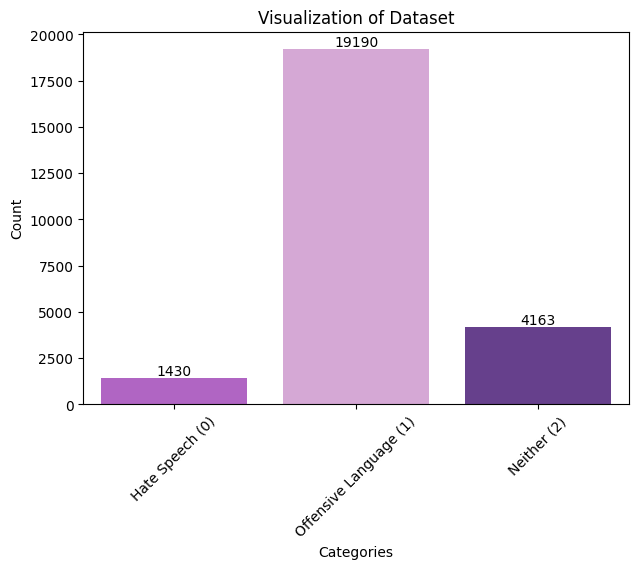

In [ ]:
# Data
category = ['Hate Speech (0)', 'Offensive Language (1)', 'Neither (2)']
count = df['class'].value_counts()
value_count = [count[0], count[1], count[2]]

# Define a purple color palette for the bar plot
bar_colors = ['mediumorchid', 'plum', 'rebeccapurple']  # Purple shades

# Create a bar chart with Seaborn
# Customize the plot
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Visualization of Dataset')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
for bar in sns.barplot(x=category, y=value_count, palette=bar_colors).patches:
  plt.annotate(int(bar.get_height()),
              (bar.get_x() + bar.get_width() / 2, bar.get_height()),
              ha='center', va='bottom')





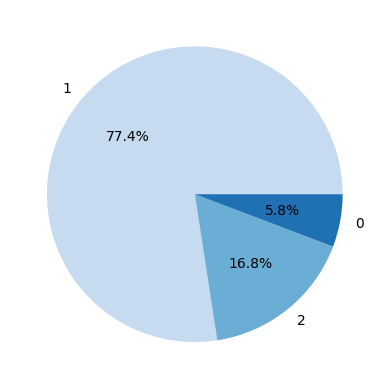

In [ ]:
blue_palette = sns.color_palette("Blues", n_colors=3)  # Customize 'n_colors' based on the number of slices

# Create a pie chart with the blue color palette
plt.pie(
    df['class'].value_counts().values,  # Values for the pie chart
    labels=df['class'].value_counts().index,  # Labels for each slice
    autopct='%1.1f%%',  # Display the percentage with one decimal place
    colors=blue_palette  # Set the color palette to shades of blue
)

# Display the pie chart
plt.show()

In [ ]:
y = df['class']
x = df.tweet

 **Balanced dataset using oversampling**

In [ ]:
#create two different dataframe of majority and minority class
df_class_1 = df1[(df1['class']==1)]
df_class_2 = df1[(df1['class']==2)]
df_class_0 = df1[(df1['class']==0)]
# undersample class_1 class
df_class_2_oversampled = resample(df_class_2,
                                 replace=True,    # sample with replacement
                                 n_samples= len(df_class_1), # to match majority class
                                 random_state=42)  # reproducible results
# undersample class_1 class
df_class_0_oversampled = resample(df_class_0,
                                 replace=True,    # sample with replacement
                                 n_samples= len(df_class_1), # to match majority class
                                 random_state=42)  # reproducible results
# Combine majority class with upsampled minority class
oversampled_df  = pd.concat([df_class_2_oversampled, df_class_0_oversampled,df_class_1])

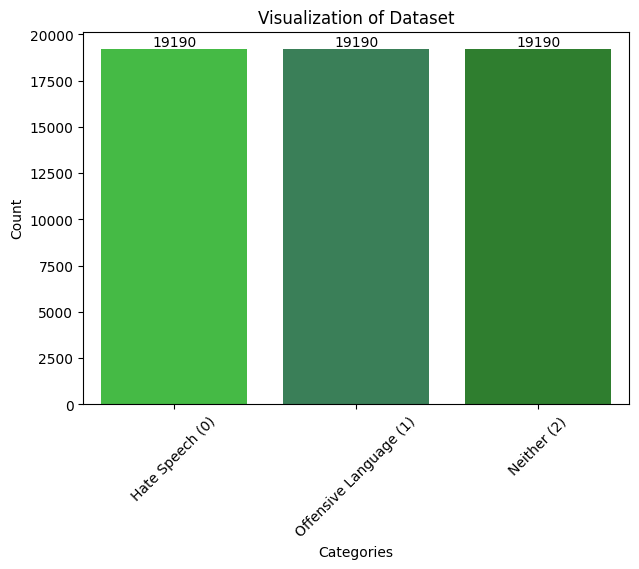

In [ ]:

# Data
category = ['Hate Speech (0)', 'Offensive Language (1)', 'Neither (2)']
count = oversampled_df['class'].value_counts()
value_count = [count[0], count[1], count[2]]

# Define a purple color palette for the bar plot
bar_colors = ['limegreen', 'seagreen', 'forestgreen']  # green shades

# Create a bar chart with Seaborn
# Customize the plot
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Visualization of Dataset')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
for bar in sns.barplot(x=category, y=value_count, palette=bar_colors).patches:
  plt.annotate(int(bar.get_height()),
              (bar.get_x() + bar.get_width() / 2, bar.get_height()),
              ha='center', va='bottom')

In [ ]:
oversampled_df

,class,tweet
5073,2,nope super chocolatey yummy brownies
22172,2,thou shall not mock ryanthe futurekelly
18219,2,rt my trash is worth more than you
2869,2,penske runs the 22 in nascar its yellow ther...
20198,2,rt a birds eye view of todays activities t...
...,...,...
24774,1,you really care bout dis bitch my dick all in ...
24775,1,you worried bout other bitches you need me for
24778,1,yous a muthafin lie right his tl is tra...
24780,1,young buck wanna eat dat nigguh like i aint fu...


**Training word2Vec model**

In [ ]:
# Define the vocabulary size and the number of words in a sequence.
vocab_size = 50000
sequence_length = 35

# Use the `TextVectorization` layer to normalize, split, and map strings to
# integers. Set the `output_sequence_length` length to pad all samples to the
# same length.
vectorize_layer = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

In [ ]:


# Assuming oversampled_df is a Pandas DataFrame with a 'tweet' column
tweets = oversampled_df['tweet'].values

# Step 1: Convert the 'tweet' column to a TensorFlow Dataset
text_ds = tf.data.Dataset.from_tensor_slices(tweets)

# Step 2: Filter out any empty tweets
text_ds = text_ds.filter(lambda x: tf.cast(tf.strings.length(x), bool))

# Step 3: Batch the dataset and adapt the vectorize_layer
vectorize_layer.adapt(text_ds.batch(1024))


In [ ]:
text_ds

<_FilterDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [ ]:
# Save the created vocabulary for reference.
inverse_vocab = vectorize_layer.get_vocabulary()
print(inverse_vocab[:20])

['', '[UNK]', 'a', 'the', 'rt', 'i', 'you', 'to', 'bitch', 'and', 'is', 'in', 'that', 'of', 'my', 'like', 'on', 'me', 'be', 'trash']


In [ ]:

# Import AUTOTUNE
AUTOTUNE = tf.data.AUTOTUNE

# Vectorize the data in text_ds
text_vector_ds = text_ds.batch(1024).prefetch(AUTOTUNE).map(vectorize_layer).unbatch()


In [ ]:
sequences = list(text_vector_ds.as_numpy_iterator())
print(len(sequences))

57570


In [ ]:
# Generates skip-gram pairs with negative sampling for a list of sequences
# (int-encoded sentences) based on window size, number of negative samples
# and vocabulary size.
def generate_training_data(sequences, window_size, num_ns, vocab_size, seed):
  # Elements of each training example are appended to these lists.
  targets, contexts, labels = [], [], []

  # Build the sampling table for `vocab_size` tokens.
  sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)

  # Iterate over all sequences (sentences) in the dataset.
  for sequence in tqdm.tqdm(sequences):

    # Generate positive skip-gram pairs for a sequence (sentence).
    positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
          sequence,
          vocabulary_size=vocab_size,
          sampling_table=sampling_table,
          window_size=window_size,
          negative_samples=0)

    # Iterate over each positive skip-gram pair to produce training examples
    # with a positive context word and negative samples.
    for target_word, context_word in positive_skip_grams:
      context_class = tf.expand_dims(
          tf.constant([context_word], dtype="int64"), 1)
      negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
          true_classes=context_class,
          num_true=1,
          num_sampled=num_ns,
          unique=True,
          range_max=vocab_size,
          seed=seed,
          name="negative_sampling")

      # Build context and label vectors (for one target word)
      context = tf.concat([tf.squeeze(context_class,1), negative_sampling_candidates], 0)
      label = tf.constant([1] + [0]*num_ns, dtype="int64")

      # Append each element from the training example to global lists.
      targets.append(target_word)
      contexts.append(context)
      labels.append(label)

  return targets, contexts, labels

In [ ]:
targets, contexts, labels = generate_training_data(
    sequences=sequences,
    window_size=2,
    num_ns=4,
    vocab_size=vocab_size,
    seed=42)

targets = np.array(targets)
contexts = np.array(contexts)
labels = np.array(labels)

print('\n')
print(f"targets.shape: {targets.shape}")
print(f"contexts.shape: {contexts.shape}")
print(f"labels.shape: {labels.shape}")

100%|██████████| 57570/57570 [03:32<00:00, 270.66it/s]




targets.shape: (468657,)
contexts.shape: (468657, 5)
labels.shape: (468657, 5)


In [ ]:
BATCH_SIZE = 1024
BUFFER_SIZE = 10000
dataset = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
print(dataset)

<_BatchDataset element_spec=((TensorSpec(shape=(1024,), dtype=tf.int64, name=None), TensorSpec(shape=(1024, 5), dtype=tf.int64, name=None)), TensorSpec(shape=(1024, 5), dtype=tf.int64, name=None))>


In [ ]:
dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)
print(dataset)


<_PrefetchDataset element_spec=((TensorSpec(shape=(1024,), dtype=tf.int64, name=None), TensorSpec(shape=(1024, 5), dtype=tf.int64, name=None)), TensorSpec(shape=(1024, 5), dtype=tf.int64, name=None))>


In [ ]:
class Word2Vec(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim):
    super(Word2Vec, self).__init__()
    self.target_embedding = layers.Embedding(vocab_size,
                                      embedding_dim,
                                      name="w2v_embedding")
    self.context_embedding = layers.Embedding(vocab_size,
                                       embedding_dim)

  def call(self, pair):
    target, context = pair
    # target: (batch, dummy?)  # The dummy axis doesn't exist in TF2.7+
    # context: (batch, context)
    if len(target.shape) == 2:
      target = tf.squeeze(target, axis=1)
    # target: (batch,)
    word_emb = self.target_embedding(target)
    # word_emb: (batch, embed)
    context_emb = self.context_embedding(context)
    # context_emb: (batch, context, embed)
    dots = tf.einsum('be,bce->bc', word_emb, context_emb)
    # dots: (batch, context)
    return dots

In [ ]:
def custom_loss(x_logit, y_true):
      return tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=y_true)

In [ ]:
embedding_dim = 128
word2vec = Word2Vec(vocab_size, embedding_dim)
word2vec.compile(optimizer='adam',
                 loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

In [ ]:
word2vec.fit(dataset, epochs=20, callbacks=[tensorboard_callback])

Epoch 1/20
457/457 ━━━━━━━━━━━━━━━━━━━━ 94s 198ms/step - accuracy: 0.4458 - loss: 1.5661
Epoch 2/20
457/457 ━━━━━━━━━━━━━━━━━━━━ 79s 173ms/step - accuracy: 0.6044 - loss: 1.2529
Epoch 3/20
457/457 ━━━━━━━━━━━━━━━━━━━━ 78s 164ms/step - accuracy: 0.7506 - loss: 0.8972
Epoch 4/20
457/457 ━━━━━━━━━━━━━━━━━━━━ 76s 166ms/step - accuracy: 0.8239 - loss: 0.6504
Epoch 5/20
457/457 ━━━━━━━━━━━━━━━━━━━━ 75s 164ms/step - accuracy: 0.8625 - loss: 0.4972
Epoch 6/20
457/457 ━━━━━━━━━━━━━━━━━━━━ 80s 161ms/step - accuracy: 0.8882 - loss: 0.3990
Epoch 7/20
457/457 ━━━━━━━━━━━━━━━━━━━━ 84s 165ms/step - accuracy: 0.9072 - loss: 0.3319
Epoch 8/20
457/457 ━━━━━━━━━━━━━━━━━━━━ 70s 154ms/step - accuracy: 0.9217 - loss: 0.2835
Epoch 9/20
457/457 ━━━━━━━━━━━━━━━━━━━━ 75s 164ms/step - accuracy: 0.9327 - loss: 0.2470
Epoch 10/20
457/457 ━━━━━━━━━━━━━━━━━━━━ 79s 158ms/step - accuracy: 0.9410 - loss: 0.2185
Epoch 11/20
457/457 ━━━━━━━━━━━━━━━━━━━━ 73s 160ms/step - accuracy: 0.9473 - loss: 0.1958
Epoch 12/20
457/457

**Data Spliting**

In [ ]:
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 250
EMBEDDING_DIM = 128

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(oversampled_df['tweet'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 20654 unique tokens.


In [ ]:
X = tokenizer.texts_to_sequences(oversampled_df['tweet'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (57570, 250)


In [ ]:
Y = pd.get_dummies(oversampled_df['class']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (57570, 3)


In [ ]:
word_embeddings = word2vec.target_embedding.get_weights()[0]

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

**Creating LSTM model**

In [ ]:
# Define the LSTM model
lstm_model = Sequential([
    Embedding(input_dim=vocab_size ,  # Size of your vocabulary
              output_dim=EMBEDDING_DIM,  # Dimension of embeddings
              weights=[word_embeddings],  # Pre-trained embeddings
              trainable=False,  # Set to False if you don't want to fine-tune embeddings
              input_length=MAX_SEQUENCE_LENGTH),  # Length of input sequences
    LSTM(units=128, return_sequences=False),  # LSTM layer with 128 units
    Dense(units=Y.shape[1], activation='softmax')  # Output layer for classification (adjust units as needed)
])

In [ ]:
lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │       6,400,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,400,000 (24.41 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 6,400,000 (24.41 MB)

In [ ]:
lstm_model.compile(optimizer='adam',
                   loss='categorical_crossentropy',  # Adjust based on your task
                   metrics=['accuracy'])

In [ ]:
tf.keras.backend.clear_session()


In [ ]:
epochs = 10
batch_size = 64

history = lstm_model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1)
accr = lstm_model.evaluate(x_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Epoch 1/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 331s 579ms/step - accuracy: 0.6218 - loss: 0.8388 - val_accuracy: 0.7886 - val_loss: 0.5374
Epoch 2/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 382s 578ms/step - accuracy: 0.8291 - loss: 0.4549 - val_accuracy: 0.8725 - val_loss: 0.3548
Epoch 3/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 386s 584ms/step - accuracy: 0.9054 - loss: 0.2759 - val_accuracy: 0.9270 - val_loss: 0.2402
Epoch 4/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 385s 589ms/step - accuracy: 0.9409 - loss: 0.1815 - val_accuracy: 0.9382 - val_loss: 0.1990
Epoch 5/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 377s 581ms/step - accuracy: 0.9599 - loss: 0.1266 - val_accuracy: 0.9439 - val_loss: 0.1900
Epoch 6/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 378s 573ms/step - accuracy: 0.9690 - loss: 0.0962 - val_accuracy: 0.9536 - val_loss: 0.1563
Epoch 7/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 383s 577ms/step - accuracy: 0.9774 - loss: 0.0747 - val_accuracy: 0.9541 - val_loss: 0.1610
Epoch 8/10
567/567 ━━━━━━━━━━━━━━━━━━━━ 371s 556ms/step - accuracy: 0.9838 -

In [ ]:
y_pred =lstm_model.predict(x_test)

540/540 ━━━━━━━━━━━━━━━━━━━━ 79s 146ms/step


**Validation**

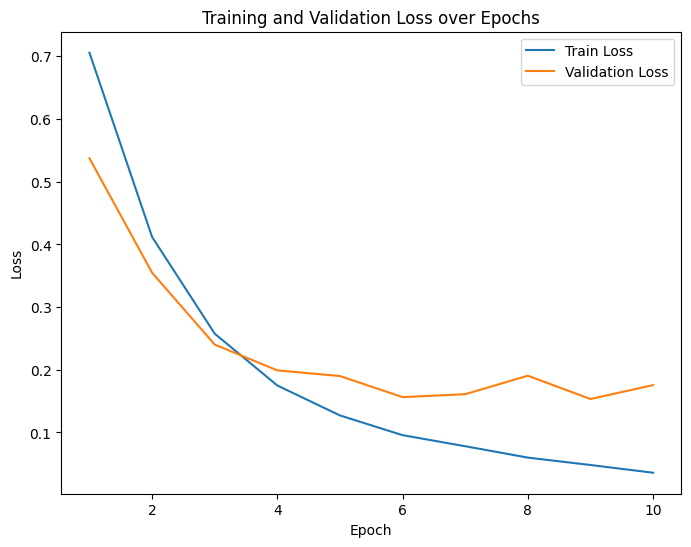

In [ ]:
epochs = list(range(1, len(history.history['loss']) + 1))  # Create a list of epochs

# Create a DataFrame for Seaborn
import pandas as pd

# Combine training and validation loss into a DataFrame
Simple_RNN_df = pd.DataFrame({
    'Epoch': epochs,
    'Train Loss': history.history['loss'],
    'Validation Loss': history.history['val_loss'],
})

# Plot with Seaborn
plt.figure(figsize=(8, 6))
sns.lineplot(data=Simple_RNN_df, x='Epoch', y='Train Loss', label='Train Loss')
sns.lineplot(data=Simple_RNN_df, x='Epoch', y='Validation Loss', label='Validation Loss')

plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

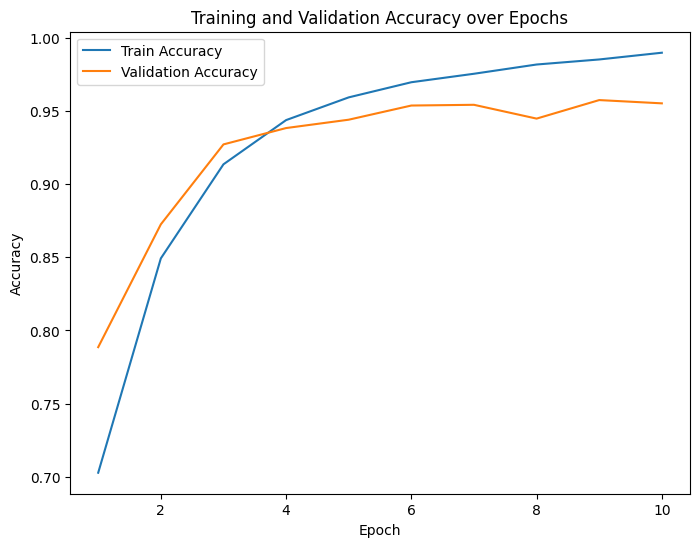

In [ ]:
epochs = list(range(1, len(history.history['accuracy']) + 1))

# Create a DataFrame for training and validation accuracy
accuracy_df = pd.DataFrame({
    'Epoch': epochs,
    'Train Accuracy': history.history['accuracy'],
    'Validation Accuracy': history.history['val_accuracy'],
})

# Plot the training and validation accuracy with Seaborn
plt.figure(figsize=(8, 6))
sns.lineplot(data=accuracy_df, x='Epoch', y='Train Accuracy', label='Train Accuracy')
sns.lineplot(data=accuracy_df, x='Epoch', y='Validation Accuracy', label='Validation Accuracy')

plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

<Axes: >

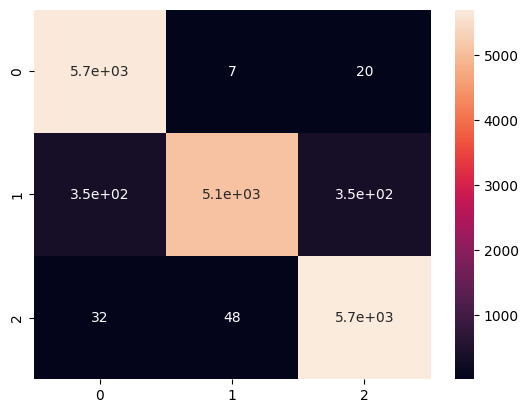

In [ ]:
cm_LSTM= confusion_matrix(np.argmax(y_test,axis=1), np.argmax(y_pred,axis=1))
sns.heatmap(data=cm_LSTM, annot=True)

In [ ]:
print(classification_report(np.argmax(y_test,axis=1), np.argmax(y_pred,axis=1),labels=[0,1,2]))

              precision    recall  f1-score   support

           0       0.94      1.00      0.96      5693
           1       0.99      0.88      0.93      5798
           2       0.94      0.99      0.96      5780

    accuracy                           0.95     17271
   macro avg       0.95      0.95      0.95     17271
weighted avg       0.95      0.95      0.95     17271



In [ ]:
new_array = [["you bitch"],["your're very good"],["you damn girl"]]
lables =['hate speech','offensive language','neither']

In [ ]:
for message in new_array:
  X = tokenizer.texts_to_sequences(message)
  X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
  output= lstm_model.predict(X)
  print(output,lables[np.argmax(output)],message,"\n")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
[[2.2340362e-04 9.9977297e-01 3.6810343e-06]] offensive language ['you bitch'] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
[[8.0142991e-04 1.3791876e-02 9.8540676e-01]] neither ["your're very good"] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
[[0.5382464  0.44286495 0.01888863]] hate speech ['you damn girl'] 

